In [3]:
import pandas as pd
import numpy as np
from data_master import DataMaster
from utils import func
from scipy.stats import norm
master = DataMaster()
from utils.func import center
from quantstats.stats import sharpe
import matplotlib.pyplot as plt
from tqdm import tqdm

In [4]:
market_data = pd.read_parquet('data/US/mkt_data.pq')
balance_sheet = pd.read_parquet('data/US/balance_sheets.pq')
GICS = pd.read_parquet('data/US/GICS.pq')
P = pd.read_parquet('data/US/universe_table.pq')
R = market_data['close'].unstack().reindex_like(P).pct_change()
market_data.dropna().sample(5)

,,datetime,open,high,low,close,adj_close,volume,MktCap
Date,Ticker,,,,,,,,
2011-06-27,CNX,2011-06-27,46.7119,47.4826,46.4116,47.1723,36.7184,2056337,1.073418e+10
2015-02-12,DOV,2015-02-12,58.5770,59.2228,58.3026,59.1501,50.2865,1113824,9.685300e+09
2017-05-22,GT,2017-05-22,31.9000,31.9200,31.3300,31.8200,29.3958,2735781,8.122880e+09
2022-06-27,IR,2022-06-27,43.6300,43.7700,42.8800,43.3900,43.3432,1800172,1.789962e+10
2013-07-29,WDC,2013-07-29,62.9200,62.9999,62.1200,62.6000,51.1872,2177403,1.540698e+10


In [5]:
import pandas_ta as ta
from tqdm import tqdm
results ={}
for ticker in tqdm(market_data.index.get_level_values(1).unique()):
    df_ticker =  market_data.xs(ticker,level=1)

    try :
        metrics = ta.ssf(df_ticker['close'],length=5,poles=2).fillna(0)
        results[ticker] = metrics
    except :
        pass

results = pd. concat (results, axis=1)
results = results.reindex_like(P).ffill()


100%|██████████| 866/866 [03:21<00:00,  4.30it/s]


C:\Users\marti\AppData\Local\Temp\ipykernel_3844\1954979550.py:2: FutureWarning: Passing additional kwargs to Rolling.rank has no impact on the result and is deprecated. This will raise a TypeError in a future version of pandas.
  signal = signal[P].rolling(10).rank(axis=0,pct=True,ascending=False)
C:\Users\marti\AppData\Local\Temp\ipykernel_3844\1954979550.py:6: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  signal = signal[P].groupby(GICS['gicgrp'],axis=1).apply(center)


Sharpe     -1.6
Turnover    0.7
biais      -2.6
dtype: float64

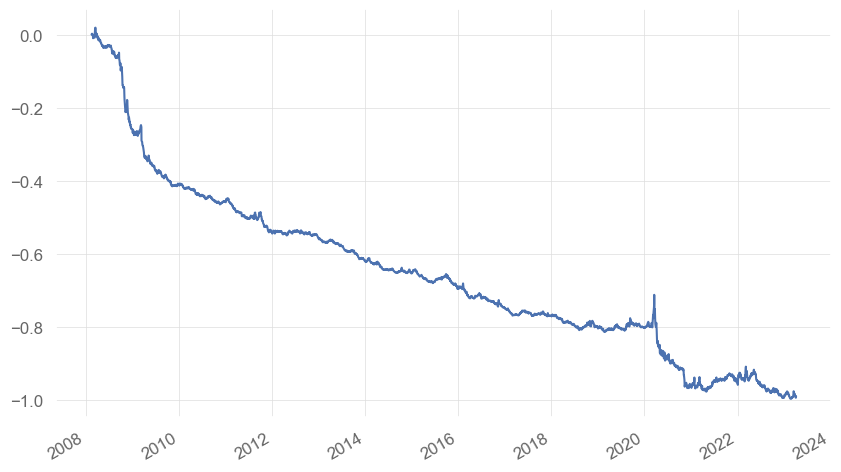

In [6]:
signal = results[P]
signal = signal[P].rolling(10).rank(axis=0,pct=True,ascending=False)
signal = signal[P].rank(axis=1,pct=True,ascending=False).clip(0.01,0.99).apply(norm.ppf)
signal[signal.abs()<0.5] = 0

signal = signal[P].groupby(GICS['gicgrp'],axis=1).apply(center)
signal = signal[P].div(signal[P].abs().sum(1),0)

PNL = (signal[P].shift()*R).sum(1).replace({0:np.nan}).dropna()
sr = sharpe(PNL)
turnover = signal.fillna(0).diff().abs().sum(1).mean()
PNL.cumsum().plot()
pd.Series({'Sharpe':sr,'Turnover':turnover,'biais':PNL.mean()*1e4}).round(1)